In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json
import datetime
import random

seed=117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Protein Disorder Prediction

### Data set-up

Import drive, so that preprocessed data can be used in Notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [3]:

def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

def read_onehot():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/onehot_data.json', 'r') as infile:
    onehot_map = json.load(infile)
    onehot_map.update((acc, np.array(onehot)) for acc, onehot in onehot_map.items())
    return onehot_map

def read_pssms():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/pssm_data.json', 'r') as infile:
    pssm_map = json.load(infile)
    pssm_map.update((acc, np.array(pssm)) for acc, pssm in pssm_map.items())
    return pssm_map

def read_homo_solution():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/homo_solution.json', 'r') as infile:
    return json.load(infile)

# Protein sequences
protein_sequences_n_ids = read_sequences()
# IDRs
pandas_data_IDRs = read_cleaned_pandas_data()
# One-hot features
onehot_map = read_onehot()
# PSSM features
pssm_map = read_pssms()
# Randomly sampled dataset split from pre-processing.
# Data leakage prevention included.
non_leaking_dataset_split = read_homo_solution()

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [4]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, vector_map, protein_sequences, ids, transform=None):
        self.disorder_prot = pandas_table
        self.vectorised_seqs = vector_map
        self.sequences = protein_sequences
        self.ids = ids
        self.tranform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.ids[idx]
        # Each row must have a unique accession number, hence we can 0 index this list
        dataframe_idx = self.disorder_prot.index[self.disorder_prot['acc'] == acc].tolist()[0]
        idrs = self.disorder_prot['disordered_regions'].loc[dataframe_idx]
        
        # Get vectorised sequence
        vectorised_protein_sequence = self.vectorised_seqs.get(acc)

        # Get protein sequence
        protein_sequence = self.sequences.get(acc)
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'seq': vectorised_protein_sequence, 'label': disorder_label}
        return get_dict

### Training model, given DisProt dataset

Separate train/validation/test datasets, with a 60/20/20 split.

One-hot feature encoding.

In [5]:
train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

PSSM feature encoding.

In [6]:
train_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_pssm_loader = DataLoader(train_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_pssm_loader = DataLoader(validation_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_pssm_loader = DataLoader(test_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

### Working with a PyTorch NN. FCN model

In [7]:
class FCN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, (20, 21), padding=(0,10))
        self.conv2 = nn.Conv2d(1, 1, (1, 21), padding=(0,10))
        self.conv3 = nn.Conv2d(1, 1, (1, 21), padding=(0,10))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = torch.sigmoid(self.conv3(x))
        x = self.conv3(x)
        return x

#### Evaluating with the Matthews correlation coefficient.
- This can be used with the validation dataset each epoch.
- This is used to evaluate the test dataset.

MCC = $\frac{(TP * TN) - (FP * FN)}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$

Where the variables are:
- TP - when a disordered protein is classified as disordered. A 1 is said to be a 1.
- FP - when an ordered protein is classified as disordered.   A 0 is said to be a 1.
- TN - when an ordered protein is classified as ordered.      A 0 is said to be a 0.
- FN - when an disordered protein is classified as ordered.   A 1 is said to be a 0.

In [8]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def calc_MCC(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  # Calculating FP
  FP = (true_label[predicted_label == 1] == 0).sum()

  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  return MCC

#### Counteracting the unbalanced dataset
- Generate a weight given the ratio of ordered to disordered amino acids.

In [9]:
def loss_weight_multiplier(loader):
  total_amino_acids = 0
  total_disordered_AA = 0
  for i, sam in enumerate(loader):
    lab = torch.squeeze(sam.get('label'))
    total_amino_acids += len(lab)
    total_disordered_AA += sum(lab)

  disordered_ratio = total_disordered_AA / total_amino_acids
  disordered_loss_weight = 1 / disordered_ratio
  return disordered_loss_weight

#### Using the Validation dataset
- Can monitor validation loss compared to training loss to prevent overfitting.
- This train and validation loop will give us results to plot the loss curves for the train and validation datasets per epoch.
- The MCC is also calculated on the validation set, given the model each epoch.

In [26]:
epoch_print_gap = 20

def train_validation_loop_with_mcc(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader, device):
    model = model.to(device)
    for epoch in range(0, n_epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0

        # Creating an iterator jumbles the sequences order, so each accumulated batch will consider different 
        # sequences over many epochs
        train_iter = iter(train_loader)

        model.train()
        # Where i is a counter and sam is a dictionary
        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          # Move features and labels to PyTorch tensors and cuda
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          # Output is the predictions
          output = model(NN_input)
          # Squeeze as we are treating each sequence as a batch, where the amino acids have been classified
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()        
          loss.backward()
          optimizer.step()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()
          
          # Print loss throughout epoch. Lets us see no 'batches' of the data are causing drastic issues.
          # Shows loss per 400 sequences of each epoch, so we can see loss throughout training.
          # Only prints on print gap
          if epoch % epoch_print_gap == 0:
            if (i+1) % 400 == 0:
              print("Epoch: "+str(epoch), end=" ")
              # Average loss over these 400 sequences
              print("Current loss: "+str(running_loss_train / 400))
              running_loss_train = 0.0
        
        # Validation data handling
        model.eval()
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(torch.sigmoid(squeezed_o)), squeezed_e_o)

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
            print("Epoch", epoch, "finished with", (total_epoch_loss/len(train_loader))," \n\n")

        epoch_loss_arr.append( (total_epoch_loss / len(train_loader)) )
        epoch_valid_loss_arr.append( (total_loss_valid / len(valid_loader)) )
        epoch_valid_MCC_arr.append( (total_MCC_valid / len(valid_loader)) )

# Main
lamb=0.001    # L2 weight decay term
lr = 0.001
epochs = 50
new_model = FCN_Net()
optimizer = optim.SGD(new_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_validation_loop_with_mcc(epochs, optimizer, new_model, criterion, train_loader, validation_loader, device)


Epoch: 0 Current loss: 1.3868389113247395
Epoch: 0 Current loss: 1.2799609164893626
Epoch: 0 Current loss: 1.2897737540304661
Epoch 0 finished with 1.3000134914953005  


Epoch: 20 Current loss: 1.1908171708509325
Epoch: 20 Current loss: 1.1395003509009256
Epoch: 20 Current loss: 1.1509595966851338
Epoch 20 finished with 1.1602758466996865  


Epoch: 40 Current loss: 1.138976460248232
Epoch: 40 Current loss: 1.172364962361753
Epoch: 40 Current loss: 1.0927100774273277
Epoch 40 finished with 1.1369186492378587  




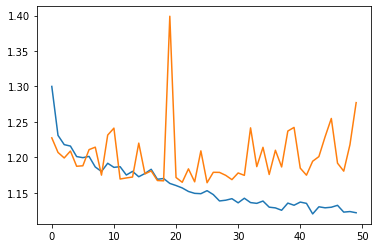

In [27]:
plt.plot(range(epochs), epoch_loss_arr)
plt.plot(range(epochs), epoch_valid_loss_arr)
plt.show()

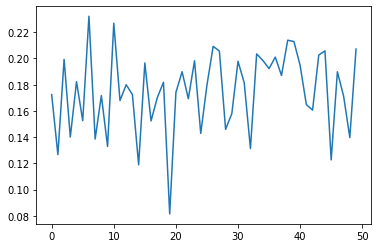

In [28]:
epoch_valid_MCC_arr_plottable = [epoch_valid_MCC_arr[i].to('cpu').numpy() if epoch_valid_MCC_arr[i] != 0 else 0.0 for i, se in enumerate(epoch_valid_MCC_arr)]
plt.plot(range(epochs), epoch_valid_MCC_arr_plottable)
plt.show()

And the PSSM model

Epoch: 0 Current loss: 1.4392959770560265
Epoch: 0 Current loss: 1.4083414660394191
Epoch: 0 Current loss: 1.382669458091259
Epoch 0 finished with 1.4042715147478584  


Epoch: 20 Current loss: 1.1722734083235264
Epoch: 20 Current loss: 1.1354825044423342
Epoch: 20 Current loss: 1.1663308419287204
Epoch 20 finished with 1.1655178680755247  


Epoch: 40 Current loss: 1.143625422939658
Epoch: 40 Current loss: 1.1061277167499066
Epoch: 40 Current loss: 1.1551879047602416
Epoch 40 finished with 1.140202855418059  




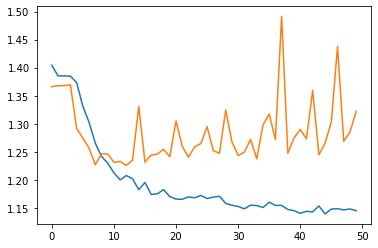

In [29]:
lamb=0.001
lr = 0.0005
epochs = 50
new_pssm_model = FCN_Net()
optimizer = optim.SGD(new_pssm_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_validation_loop_with_mcc(epochs, optimizer, new_pssm_model, criterion, train_pssm_loader, validation_pssm_loader, device)

plt.plot(range(epochs), epoch_loss_arr)
plt.plot(range(epochs), epoch_valid_loss_arr)
plt.show()

#### Tuning Hyperparameters

In [31]:
#pip install -U ray

In [10]:
# Note ray often needs to be reinstalled, so uncomment and install this if the following imports do not work
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

From our above analysis of manually changing parameters we see improvements to the loss are made fairly quickly but not too quickly, so we use a grace period of 15. We also see after about 30-40 epochs from using different parameters, the one-hot model does not improve on the validation set, therefore we will not run our training loop for longer than this. For the pssm model, these epochs will be lowered to 30 for this experiment. From manual experimentation we also see a lower learning rate and weight decay is more optimal, therefore we have selected values in this range to be experimented on. For our PSSM model in particular, a low learning rate was necessary so this was considered in our parameter choices.

In [11]:
def train_and_eval(config):
    
    # Call the remote function and pass in the object reference as memory issues occur trying to access the global variables, or passing them in locally
    train_loader = ray.get(train_object_ref)
    valid_loader = ray.get(validation_object_ref)

    lamb = config['lamb']
    lr = config['lr']
    epochs = config['epochs']
    model = FCN_Net()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
    use_cuda = True
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    disordered_loss_weight = loss_weight_multiplier(train_loader)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))
    
    model = model.to(device)
    best_val_loss = float('inf')
    for epoch in range(0, epochs):

        # Training data handling
        total_epoch_loss = 0.0
        train_iter = iter(train_loader)

        model.train()
        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()
          loss.backward()
          total_epoch_loss += loss.item()
          optimizer.step()
        

        # Validation data handling
        model.eval()
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(torch.sigmoid(squeezed_o)), squeezed_e_o)

        # Validation statistics for selecting best hyperparameters
        average_loss = total_loss_valid / len(valid_loader)
        average_mcc = total_MCC_valid / len(valid_loader)

        if average_loss < best_val_loss:
          best_val_loss = average_loss
          with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = drive_checkpoint_dir + '/checkpoint'
            torch.save(model.state_dict(), path)

        tune.report(loss=best_val_loss) #, mcc=average_mcc)


In [14]:
config = {
    "lr": tune.choice([0.0005, 0.001, 0.005]),
    "lamb": tune.choice([0.001, 0.005, 0.01]),
    "epochs": 40
}

ray.init(num_gpus=1, ignore_reinit_error=True)

# Create references for data loaders due to memory issues
train_object_ref = ray.put(train_loader)
validation_object_ref = ray.put(validation_loader)

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=10
)

reporter = CLIReporter()

drive_checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/ray_results'

analysis = tune.run(
    train_and_eval,
    config=config,
    resources_per_trial=tune.PlacementGroupFactory(
        [{'GPU': 1.0, 'CPU': 1.0}] + [{'CPU': 1.0}] * 1
    ),
    num_samples=10,
    local_dir=drive_checkpoint_dir,
    scheduler=scheduler,
    progress_reporter=reporter,
)


2023-03-12 23:13:01,508	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.
2023-03-12 23:13:01,851	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-03-12 23:13:05 (running for 00:00:03.90)
Memory usage on this node: 3.4/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+
| Trial name                 | status   | loc               |   lamb |     lr |
|----------------------------+----------+-------------------+--------+--------|
| train_and_eval_6f9a9_00000 | RUNNING  | 172.28.0.12:22081 |  0.001 | 0.001  |
| train_and_eval_6f9a9_00001 | PENDING  |                   |  0.01  | 0.0005 |
| train_and_eval_6f9a9_00002 | PENDING  |                   |  0.001 | 0.005  |
| train_and_eval_6f9a9_00003 | PENDING  |                   |  0.01  | 0.0005 |
| train_and

(train_and_eval pid=22081) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=22081)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:13:10 (running for 00:00:08.90)
Memory usage on this node: 4.4/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+
| Trial name                 | status   | loc               |   lamb |     lr |
|----------------------------+----------+-------------------+--------+--------|
| train_and_eval_6f9a9_00000 | RUNNING  | 172.28.0.12:22081 |  0.001 | 0.001  |
| train_and_eval_6f9a9_00001 | PENDING  |                   |  0.01  | 0.0005 |
| train_and_eval_6f9a9_00002 | PENDING  |                   |  0.001 | 0.005  |
| train_and_eval_6f9a9_00003 | PENDING  |                   |  0.01  | 0.0005 |
| train_and

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_and_eval_6f9a9_00000,2023-03-12_23-17-55,True,,944d8ad57c724ead9d7688a2172c6a0e,6f554b2c9378,40,1.16985,172.28.0.12,22081,289.803,6.45447,289.803,1678663075,0,,40,6f9a9_00000,0.00419164
train_and_eval_6f9a9_00001,2023-03-12_23-19-13,True,,dddab17d9710445baa984dc1cb04069b,6f554b2c9378,10,1.36507,172.28.0.12,23393,73.6042,5.48485,73.6042,1678663153,0,,10,6f9a9_00001,0.00415325
train_and_eval_6f9a9_00002,2023-03-12_23-23-45,True,,477f60f67c4b4b75865693da5f48b914,6f554b2c9378,40,1.19103,172.28.0.12,23764,268.882,6.49098,268.882,1678663425,0,,40,6f9a9_00002,0.00507188
train_and_eval_6f9a9_00003,2023-03-12_23-25-04,True,,d677afb4ef974897b52d415cd67f2b12,6f554b2c9378,10,1.18668,172.28.0.12,24983,75.0296,7.56172,75.0296,1678663504,0,,10,6f9a9_00003,0.00375581
train_and_eval_6f9a9_00004,2023-03-12_23-26-21,True,,648b7c815c2544fba2d3856ea30202f3,6f554b2c9378,10,1.36604,172.28.0.12,25379,72.345,6.11966,72.345,1678663581,0,,10,6f9a9_00004,0.00519562
train_and_eval_6f9a9_00005,2023-03-12_23-27-36,True,,7b609e9db13441d7894b000f730e9894,6f554b2c9378,10,1.36571,172.28.0.12,25764,72.5618,5.6986,72.5618,1678663656,0,,10,6f9a9_00005,0.0051651
train_and_eval_6f9a9_00006,2023-03-12_23-32-09,True,,b1d44ed08cf94f06968a80b0543ac08f,6f554b2c9378,40,1.1749,172.28.0.12,26143,267.81,5.46184,267.81,1678663929,0,,40,6f9a9_00006,0.00477338
train_and_eval_6f9a9_00007,2023-03-12_23-33-27,True,,143e3d6370f24c14adf98859171948da,6f554b2c9378,10,1.36501,172.28.0.12,27397,74.3554,6.65006,74.3554,1678664007,0,,10,6f9a9_00007,0.00574732
train_and_eval_6f9a9_00008,2023-03-12_23-38-01,True,,1f9a506bb0f5483dbc55c0ce21f3a481,6f554b2c9378,40,1.16145,172.28.0.12,27787,270.889,5.93607,270.889,1678664281,0,,40,6f9a9_00008,0.00488138
train_and_eval_6f9a9_00009,2023-03-12_23-39-21,True,,549e6bb0860f49afb62824b4f6075b40,6f554b2c9378,10,1.36529,172.28.0.12,29052,76.2036,8.25931,76.2036,1678664361,0,,10,6f9a9_00009,0.00593352


== Status ==
Current time: 2023-03-12 23:13:24 (running for 00:00:22.73)
Memory usage on this node: 5.8/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status   | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+----------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00000 | RUNNING  | 172.28.0.12:22081 |  0.001 | 0.001  |      1 |          13.8017 | 1.35795 |
| train_and_eval_6f9a9_00001 | PENDING  |                   |  0.01  | 0.0005 |        |           

(train_and_eval pid=23393) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=23393)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:18:01 (running for 00:04:59.44)
Memory usage on this node: 3.5/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: -1.1698462595955288 | Iter 10.000: -1.1698462595955288
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00001 | RUNNING    | 172.28.0.12:23393 |  0.01  | 0.0005 |        |                  |         |
| train_and_eval_6f9a9_00002 | PENDING    |    

(train_and_eval pid=23764) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=23764)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:19:18 (running for 00:06:16.42)
Memory usage on this node: 3.5/12.7 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 40.000: -1.1698462595955288 | Iter 10.000: -1.2186528642374526
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00002 | RUNNING    | 172.28.0.12:23764 |  0.001 | 0.005  |        |                  |         |
| train_and_eval_6f9a9_00003 | PENDING    |    

(train_and_eval pid=24983) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=24983)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:23:51 (running for 00:10:49.50)
Memory usage on this node: 3.5/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 40.000: -1.1751425021065143 | Iter 10.000: -1.184963091066682
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00003 | RUNNING    | 172.28.0.12:24983 |  0.01  | 0.0005 |        |                  |         |
| train_and_eval_6f9a9_00004 | PENDING    |     

(train_and_eval pid=25379) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=25379)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:25:14 (running for 00:12:12.55)
Memory usage on this node: 4.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 40.000: -1.1751425021065143 | Iter 10.000: -1.1824720219283056
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00004 | RUNNING    | 172.28.0.12:25379 |  0.005 | 0.0005 |        |                  |         |
| train_and_eval_6f9a9_00005 | PENDING    |    

(train_and_eval pid=25764) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=25764)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:26:26 (running for 00:13:24.49)
Memory usage on this node: 3.5/12.7 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 40.000: -1.1751425021065143 | Iter 10.000: -1.1866806093725646
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00005 | RUNNING    | 172.28.0.12:25764 |  0.005 | 0.005  |        |                  |         |
| train_and_eval_6f9a9_00006 | PENDING    |    

(train_and_eval pid=26143) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=26143)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:27:42 (running for 00:14:40.53)
Memory usage on this node: 3.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 40.000: -1.1751425021065143 | Iter 10.000: -1.1900304376638822
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00006 | RUNNING    | 172.28.0.12:26143 |  0.01  | 0.001  |        |                  |         |
| train_and_eval_6f9a9_00007 | PENDING    |    

(train_and_eval pid=27397) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=27397)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:32:14 (running for 00:19:12.54)
Memory usage on this node: 3.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 40.000: -1.1723741202633544 | Iter 10.000: -1.186383924595767
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00007 | RUNNING    | 172.28.0.12:27397 |  0.005 | 0.0005 |        |                  |         |
| train_and_eval_6f9a9_00008 | PENDING    |     

(train_and_eval pid=27787) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=27787)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:33:32 (running for 00:20:30.56)
Memory usage on this node: 3.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 40.000: -1.1723741202633544 | Iter 10.000: -1.1865322669841658
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00008 | RUNNING    | 172.28.0.12:27787 |  0.01  | 0.0005 |        |                  |         |
| train_and_eval_6f9a9_00009 | PENDING    |    

(train_and_eval pid=29052) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=29052)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:38:06 (running for 00:25:04.65)
Memory usage on this node: 3.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 40.000: -1.167747484687186 | Iter 10.000: -1.1860872398189695
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00009 | RUNNING    | 172.28.0.12:29052 |  0.005 | 0.0005 |        |                  |         |
| train_and_eval_6f9a9_00000 | TERMINATED | 172.28.0.12:220

2023-03-12 23:39:21,816	INFO tune.py:798 -- Total run time: 1579.98 seconds (1579.90 seconds for the tuning loop).


== Status ==
Current time: 2023-03-12 23:39:21 (running for 00:26:19.95)
Memory usage on this node: 5.2/12.7 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 40.000: -1.167747484687186 | Iter 10.000: -1.1862355822073682
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-13-01
Number of trials: 10/10 (10 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_6f9a9_00000 | TERMINATED | 172.28.0.12:22081 |  0.001 | 0.001  |     40 |         289.803  | 1.16985 |
| train_and_eval_6f9a9_00001 | TERMINATED | 172.28.0.12:23393 |  0.01  | 

We can see in the above table that . <br>Our best parameters:

In [15]:
best_trial = analysis.get_best_trial(metric="loss", mode="min")
print(best_trial)
best_config = best_trial.config
print(best_config)
best_lamb = best_trial.config["lamb"]
print(best_lamb)
best_lr = best_trial.config["lr"]
print(best_lr)

train_and_eval_6f9a9_00008
{'lr': 0.0005, 'lamb': 0.01, 'epochs': 40}
0.01
0.0005


And PSSMs.

In [16]:
config = {
    "lr": tune.choice([0.0005, 0.00075, 0.001, 0.0025]),
    "lamb": tune.choice([0.001, 0.005, 0.01]),
    "epochs": 30
}

ray.init(num_gpus=1, ignore_reinit_error=True)

# Create references for data loaders due to memory issues
train_object_ref = ray.put(train_pssm_loader)
validation_object_ref = ray.put(validation_pssm_loader)

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=10
)

reporter = CLIReporter()

drive_checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/ray_results'

pssm_analysis = tune.run(
    train_and_eval,
    config=config,
    resources_per_trial=tune.PlacementGroupFactory(
        [{'GPU': 1.0, 'CPU': 1.0}] + [{'CPU': 1.0}] * 1
    ),
    num_samples=10,
    local_dir=drive_checkpoint_dir,
    scheduler=scheduler,
    progress_reporter=reporter,
)

2023-03-12 23:39:21,948	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.
2023-03-12 23:39:22,423	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-03-12 23:39:25 (running for 00:00:02.70)
Memory usage on this node: 3.9/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+---------+
| Trial name                 | status   | loc               |   lamb |      lr |
|----------------------------+----------+-------------------+--------+---------|
| train_and_eval_1db2c_00000 | RUNNING  | 172.28.0.12:29488 |  0.01  | 0.0025  |
| train_and_eval_1db2c_00001 | PENDING  |                   |  0.001 | 0.00075 |
| train_and_eval_1db2c_00002 | PENDING  |                   |  0.001 | 0.0025  |
| train_and_eval_1db2c_00003 | PENDING  |                   |  0.005 | 0.001   |
| tr

(train_and_eval pid=29488) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=29488)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:39:30 (running for 00:00:07.71)
Memory usage on this node: 4.8/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+---------+
| Trial name                 | status   | loc               |   lamb |      lr |
|----------------------------+----------+-------------------+--------+---------|
| train_and_eval_1db2c_00000 | RUNNING  | 172.28.0.12:29488 |  0.01  | 0.0025  |
| train_and_eval_1db2c_00001 | PENDING  |                   |  0.001 | 0.00075 |
| train_and_eval_1db2c_00002 | PENDING  |                   |  0.001 | 0.0025  |
| train_and_eval_1db2c_00003 | PENDING  |                   |  0.005 | 0.001   |
| tr

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_and_eval_1db2c_00000,2023-03-12_23-42-48,True,,2d71cd73f96f49f99c1d5fe22619da7d,"0_lamb=0.0100,lr=0.0025",6f554b2c9378,30,1.26432,172.28.0.12,29488,203.767,6.03701,203.767,1678664568,0,,30,1db2c_00000,0.00388408
train_and_eval_1db2c_00001,2023-03-12_23-44-06,True,,d2a4e385e33f49e8976a7e85f4ffd557,,6f554b2c9378,10,1.29427,172.28.0.12,30452,74.0064,6.25005,74.0064,1678664646,0,,10,1db2c_00001,0.00371218
train_and_eval_1db2c_00002,2023-03-12_23-45-23,True,,210fdd75264848c0b16c6d7703e8144f,,6f554b2c9378,10,1.2828,172.28.0.12,30844,73.846,5.65381,73.846,1678664723,0,,10,1db2c_00002,0.00408196
train_and_eval_1db2c_00003,2023-03-12_23-48-55,True,,7a0cfe4aba544fd6a81302ff9126044b,"3_lamb=0.0050,lr=0.0010",6f554b2c9378,30,1.26514,172.28.0.12,31233,206.364,8.09077,206.364,1678664935,0,,30,1db2c_00003,0.00581527
train_and_eval_1db2c_00004,2023-03-12_23-50-12,True,,064ed05e67514e0595e1a164a857b326,,6f554b2c9378,10,1.36498,172.28.0.12,32212,72.8319,5.42418,72.8319,1678665012,0,,10,1db2c_00004,0.00377464
train_and_eval_1db2c_00005,2023-03-12_23-51-36,True,,e03c7193ccb648f38469e9edb17a3d15,,6f554b2c9378,10,1.36468,172.28.0.12,32598,80.9217,5.43251,80.9217,1678665096,0,,10,1db2c_00005,0.00436664
train_and_eval_1db2c_00006,2023-03-12_23-53-01,True,,880342d3d60e4f0f9822a3c933b814ba,,6f554b2c9378,10,1.36503,172.28.0.12,33019,79.6941,5.66432,79.6941,1678665181,0,,10,1db2c_00006,0.0104079
train_and_eval_1db2c_00007,2023-03-12_23-54-23,True,,078d4500d1ab4887835ecce0bf034823,,6f554b2c9378,10,1.30285,172.28.0.12,33446,77.9691,6.02667,77.9691,1678665263,0,,10,1db2c_00007,0.00412846
train_and_eval_1db2c_00008,2023-03-12_23-57-59,True,,ccc37e136e464d61b1c7e476e50647d1,"8_lamb=0.0010,lr=0.0010",6f554b2c9378,30,1.27717,172.28.0.12,33858,210.911,8.3523,210.911,1678665479,0,,30,1db2c_00008,0.00515866
train_and_eval_1db2c_00009,2023-03-13_00-01-28,True,,0084b153e9344819a33f472e1d41cb9c,"9_lamb=0.0050,lr=0.0005",6f554b2c9378,30,1.26307,172.28.0.12,34852,205.227,6.90302,205.227,1678665688,0,,30,1db2c_00009,0.00397372


== Status ==
Current time: 2023-03-12 23:39:44 (running for 00:00:22.45)
Memory usage on this node: 6.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status   | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+----------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00000 | RUNNING  | 172.28.0.12:29488 |  0.01  | 0.0025  |      1 |          14.7265 | 1.32084 |
| train_and_eval_1db2c_00001 | PENDING  |                   |  0.001 | 0.00075 |        |      

(train_and_eval pid=30452) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=30452)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:42:54 (running for 00:03:32.08)
Memory usage on this node: 4.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: -1.2759722237774789
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00001 | RUNNING    | 172.28.0.12:30452 |  0.001 | 0.00075 |        |                  |         |
| train_and_eval_1db2c_00002 | PENDING    |               

(train_and_eval pid=30844) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=30844)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:44:11 (running for 00:04:49.15)
Memory usage on this node: 4.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 40.000: None | Iter 10.000: -1.280545943121159
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00002 | RUNNING    | 172.28.0.12:30844 |  0.001 | 0.0025  |        |                  |         |
| train_and_eval_1db2c_00003 | PENDING    |                

(train_and_eval pid=31233) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=31233)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:45:34 (running for 00:06:12.31)
Memory usage on this node: 4.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 40.000: None | Iter 10.000: -1.27938521090952
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00003 | RUNNING    | 172.28.0.12:31233 |  0.005 | 0.001   |        |                  |         |
| train_and_eval_1db2c_00004 | PENDING    |                 

(train_and_eval pid=32212) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=32212)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:49:01 (running for 00:09:39.17)
Memory usage on this node: 4.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 40.000: None | Iter 10.000: -1.2739355913984958
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00004 | RUNNING    | 172.28.0.12:32212 |  0.01  | 0.0025  |        |                  |         |
| train_and_eval_1db2c_00005 | PENDING    |               

(train_and_eval pid=32598) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=32598)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:50:17 (running for 00:10:55.20)
Memory usage on this node: 4.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 40.000: None | Iter 10.000: -1.2759722237774789
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00005 | RUNNING    | 172.28.0.12:32598 |  0.01  | 0.001   |        |                  |         |
| train_and_eval_1db2c_00006 | PENDING    |               

(train_and_eval pid=33019) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=33019)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:51:47 (running for 00:12:24.74)
Memory usage on this node: 4.1/12.7 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 40.000: None | Iter 10.000: -1.2776787173434994
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00006 | RUNNING    | 172.28.0.12:33019 |  0.01  | 0.001   |        |                  |         |
| train_and_eval_1db2c_00007 | PENDING    |               

(train_and_eval pid=33446) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=33446)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:53:07 (running for 00:13:45.27)
Memory usage on this node: 4.1/12.7 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 40.000: None | Iter 10.000: -1.27938521090952
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00007 | RUNNING    | 172.28.0.12:33446 |  0.005 | 0.0025  |        |                  |         |
| train_and_eval_1db2c_00008 | PENDING    |                 

(train_and_eval pid=33858) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=33858)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:54:29 (running for 00:15:07.35)
Memory usage on this node: 4.1/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 40.000: None | Iter 10.000: -1.2810917044755405
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00008 | RUNNING    | 172.28.0.12:33858 |  0.001 | 0.001   |        |                  |         |
| train_and_eval_1db2c_00009 | PENDING    |               

(train_and_eval pid=34852) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=34852)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-12 23:58:04 (running for 00:18:42.46)
Memory usage on this node: 4.0/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 40.000: None | Iter 10.000: -1.2771748927802955
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00009 | RUNNING    | 172.28.0.12:34852 |  0.005 | 0.0005  |        |                  |         |
| train_and_eval_1db2c_00000 | TERMINATED | 172.28.0.12:29488 |  0.01

2023-03-13 00:01:28,624	INFO tune.py:798 -- Total run time: 1326.21 seconds (1326.15 seconds for the tuning loop).


== Status ==
Current time: 2023-03-13 00:01:28 (running for 00:22:06.18)
Memory usage on this node: 6.2/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 40.000: None | Iter 10.000: -1.276272891028183
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-12_23-39-22
Number of trials: 10/10 (10 TERMINATED)
+----------------------------+------------+-------------------+--------+---------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |      lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+---------+--------+------------------+---------|
| train_and_eval_1db2c_00000 | TERMINATED | 172.28.0.12:29488 |  0.01  | 0.0025  |     30 |         203.767  | 1.26432 |
| train_and_eval_1db2c_00001 | TERMINATED | 172.28.0.12:30452 |  0.001 | 0.00075 |  

In [17]:
best_trial = pssm_analysis.get_best_trial(metric="loss", mode="min")
print(best_trial)
best_config = best_trial.config
print(best_config)
best_lamb = best_trial.config["lamb"]
print(best_lamb)
best_lr = best_trial.config["lr"]
print(best_lr)

train_and_eval_1db2c_00009
{'lr': 0.0005, 'lamb': 0.005, 'epochs': 30}
0.005
0.0005


### Training final models

In [18]:
def full_train(epochs, optimizer, model, loss_fn, train_loader, device):
    model = model.to(device)
    model.train()
    for epoch in range(0, epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0
        train_iter = iter(train_loader)

        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          # Output is the predictions
          output = model(NN_input)
          # Squeeze as we are treating each sequence as a batch, where the amino acids have been classified
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
          print("Epoch", epoch, "finished with", (total_epoch_loss/len(train_loader))," \n\n")

In [19]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation']
total_train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, full_training_dataset)

train_loader = DataLoader(total_train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


lamb = analysis.get_best_trial(metric="loss", mode="min").config["lamb"] #0.01
lr = analysis.get_best_trial(metric="loss", mode="min").config["lr"] #0.0005
epochs = 40
epoch_print_gap = 10
final_fcn_model_one_hot = FCN_Net()
optimizer = optim.SGD(final_fcn_model_one_hot.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_fcn_model_one_hot, loss_fn, train_loader, device)

Epoch 0 finished with 1.402722443279015  


Epoch 10 finished with 1.1852407764817905  


Epoch 20 finished with 1.1747608892830512  


Epoch 30 finished with 1.1653545336261952  




In [23]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation']
total_pssm_train_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, full_training_dataset)

train_pssm_loader = DataLoader(total_pssm_train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

# Due to Colab's limited run time these have been filled in manually from being printed out in the Notebook.
# To recomplete the full experiment, add the analysis best value lookups back in.
lamb = pssm_analysis.get_best_trial(metric="loss", mode="min").config["lamb"] #0.005
lr = pssm_analysis.get_best_trial(metric="loss", mode="min").config["lr"] #0.0005
epochs = 30
epoch_print_gap = 5
final_fcn_model_pssm = FCN_Net()
optimizer = optim.SGD(final_fcn_model_pssm.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_fcn_model_pssm, loss_fn, train_pssm_loader, device)

Epoch 0 finished with 1.4188629415191085  


Epoch 5 finished with 1.393308441723614  


Epoch 10 finished with 1.2558837866298451  


Epoch 15 finished with 1.2203898191359996  


Epoch 20 finished with 1.1949010712702866  


Epoch 25 finished with 1.1946023919965212  




Evaluating MCC over entire test dataset.

In [20]:
def calculate_dataset_mcc(name, dataset, model):
  test_mcc_score = 0

  model.eval()
  for seq in dataset:
    input_seq = seq.get('seq')
    input_seq = input_seq.type(torch.FloatTensor)
    input_seq = input_seq.to(device)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)
    true_label = true_label.to(device)

    with torch.no_grad():
      predicted_label = model(input_seq)
    
    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    test_mcc_score += calc_MCC(pred_lab, true_label)

  print(name+" MCC score: ", ( test_mcc_score / len(dataset) ))

In [24]:
#calculate_dataset_mcc("Test", test_loader, final_fcn_model_one_hot)
calculate_dataset_mcc("Test", test_pssm_loader, final_fcn_model_pssm)

Test MCC score:  tensor(0.0757, device='cuda:0')


### Saving model - for later use.

In [26]:
# Writes trained model to storage
def write_model(model, fname):

  model = model.to("cpu")
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/'+fname
  torch.save(model.state_dict(), PATH)

#write_model(final_fcn_model_one_hot, '1hot_2D_cnn_net.pth')
write_model(final_fcn_model_pssm, 'pssm_2D_cnn_net.pth')